# Assignment 02 - Team Galaxy
### Collaborators: Alvaro Montoya Ruiz, Hriday Reddy Purma, Mauricio Bermudez

### A. Library Imports


In [ ]:
import torch
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim

### B. Setting device and processing/cleaning our data

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
url = 'https://raw.githubusercontent.com/m-bermudez/ISM6561-Deep-Learning/refs/heads/main/EmployeeAttrition.csv'
df = pd.read_csv(url)

# Data cleaning and preprocessing
df = df.dropna()  # Drop missing values

### C. Encoding our data

In [ ]:
# Ordinal Mapping for 'BusinessTravel' column
business_travel_mapping = {
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}
df['BusinessTravel'] = df['BusinessTravel'].map(business_travel_mapping)

# One-Hot Encoding for Nominal Columns
nominal_columns = [
    'Department',
    'EducationField',
    'Gender',
    'JobRole',
    'MaritalStatus'
]
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

# Binary Encoding for 'Over18', 'Overtime', and 'Attrition'
df['Over18'] = df['Over18'].map({'Y': 1, 'N': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Drop 'EmployeeCount' and 'EmployeeNumber' columns
df = df.drop(columns=['EmployeeCount', 'EmployeeNumber'])

# Ensure all columns are numeric and of type float32
df = df.apply(pd.to_numeric, errors='coerce').astype('float32')

Epoch [1/50], Train Loss: 0.6019, Train Accuracy: 0.7765, Val Loss: 0.5077, Val Accuracy: 0.8545
Epoch [2/50], Train Loss: 0.4745, Train Accuracy: 0.8377, Val Loss: 0.3991, Val Accuracy: 0.8636
Epoch [3/50], Train Loss: 0.4067, Train Accuracy: 0.8435, Val Loss: 0.3590, Val Accuracy: 0.8818
Epoch [4/50], Train Loss: 0.3756, Train Accuracy: 0.8562, Val Loss: 0.3329, Val Accuracy: 0.8773
Epoch [5/50], Train Loss: 0.3647, Train Accuracy: 0.8533, Val Loss: 0.3261, Val Accuracy: 0.8864
Epoch [6/50], Train Loss: 0.3523, Train Accuracy: 0.8591, Val Loss: 0.3326, Val Accuracy: 0.9000
Epoch [7/50], Train Loss: 0.3371, Train Accuracy: 0.8756, Val Loss: 0.3258, Val Accuracy: 0.8909
Epoch [8/50], Train Loss: 0.3300, Train Accuracy: 0.8678, Val Loss: 0.3259, Val Accuracy: 0.9000
Epoch [9/50], Train Loss: 0.3312, Train Accuracy: 0.8707, Val Loss: 0.3318, Val Accuracy: 0.9000
Epoch [10/50], Train Loss: 0.3363, Train Accuracy: 0.8669, Val Loss: 0.3264, Val Accuracy: 0.9045
Epoch [11/50], Train Loss: 0.

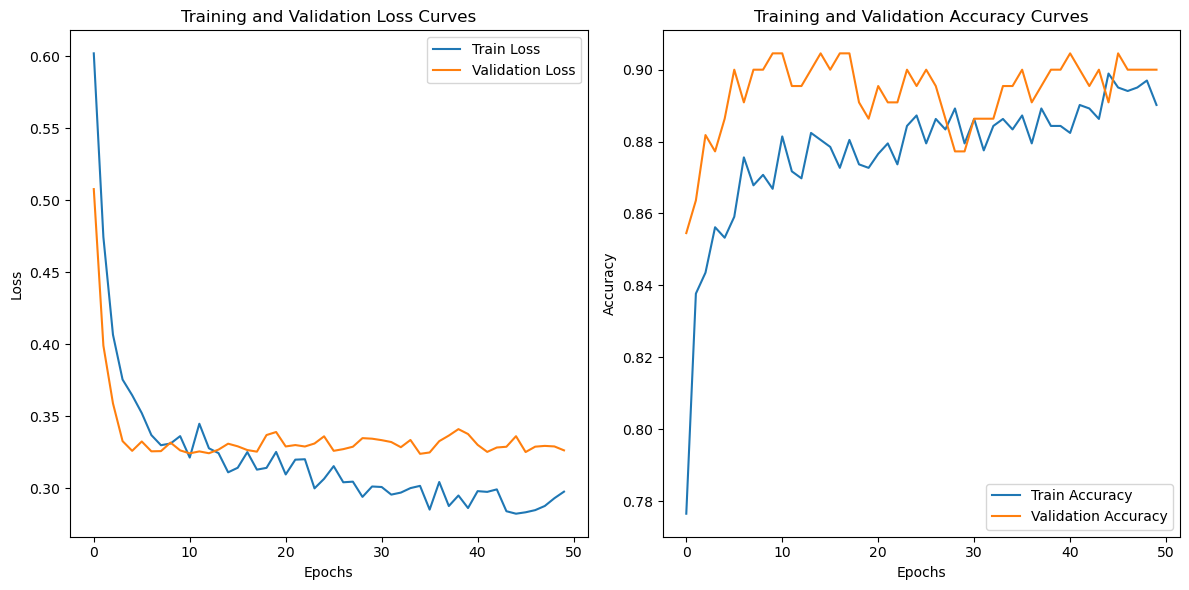

In [1]:
# Define features and target
y = df['Attrition']
X = df.drop('Attrition', axis=1)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network
class MLP(nn.Module):
    def __init__(self, input_size=None):
        super(MLP, self).__init__()
        if input_size is None:
            input_size = X_train.shape[1]
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.elu(self.fc2(x))
        x = self.dropout(x)
        x = self.elu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    accuracy_metric = torchmetrics.Accuracy(task='binary').to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            accuracy = accuracy_metric(preds, targets)

            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy.item() * inputs.size(0)

        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)

                # Compute accuracy
                preds = (outputs > 0.5).float()
                accuracy = accuracy_metric(preds, targets)

                val_loss += loss.item() * inputs.size(0)
                val_accuracy += accuracy.item() * inputs.size(0)

        # Compute average validation loss and accuracy for the epoch
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_accuracy / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Initialize model, loss function, and optimizer
model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50
)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()